<a href="https://colab.research.google.com/github/mezaga/ACIML/blob/aciml-06%2F10%2F22/ACIML_seminario_prototype_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ACIML Prototipo**

Gerardo Meza, UNAM





---

DESCARGA DE AUDIOS:
https://drive.google.com/file/d/1KW_QrFYsts3ccMv222hJsOLWHKCPdCb_/view?usp=sharing


In [ ]:
#@title Carga de Librerias
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1P--SbiazyeD_m3Nxhuz331knZ2B-iWZO' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1P--SbiazyeD_m3Nxhuz331knZ2B-iWZO" -O encoder2_cdmx.zip && rm -rf /tmp/cookies.txt
!unzip /content/encoder2_cdmx.zip
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=169SFhtDzPuoM0d5YzIdRVjx3C-8dSB7o' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=169SFhtDzPuoM0d5YzIdRVjx3C-8dSB7o" -O decoder2_cdmx.zip && rm -rf /tmp/cookies.txt
!unzip /content/decoder2_cdmx.zip

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1egipBGfxnvWiDE4C0wgr2uO2-xfK3t3R' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1egipBGfxnvWiDE4C0wgr2uO2-xfK3t3R" -O vanilla_encoder.zip && rm -rf /tmp/cookies.txt
!unzip /content/vanilla_encoder.zip
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=12XmcSvVEsn3Fdg-SoCGxQGZdKQTSHeDU' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=12XmcSvVEsn3Fdg-SoCGxQGZdKQTSHeDU" -O vanilla_decoder.zip && rm -rf /tmp/cookies.txt
!unzip /content/vanilla_decoder.zip

from sklearn.preprocessing import StandardScaler
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import IPython
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras import layers
from keras.models import Model
from keras import backend as K
from sklearn.decomposition import  PCA
from mpl_toolkits.mplot3d import Axes3D
import IPython
import pickle
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import random
AUDIO_LOAD = []
etiquetas = []
track_num = []

--2022-11-07 15:17:55--  https://docs.google.com/uc?export=download&confirm=t&id=1P--SbiazyeD_m3Nxhuz331knZ2B-iWZO
Resolving docs.google.com (docs.google.com)... 209.85.234.139, 209.85.234.102, 209.85.234.138, ...
Connecting to docs.google.com (docs.google.com)|209.85.234.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f7pdton09itls0gj00hkp40ji3r1par9/1667834250000/00101780325229425041/*/1P--SbiazyeD_m3Nxhuz331knZ2B-iWZO?e=download&uuid=53ec70d8-da2e-4b68-9b42-e1f9a581c929 [following]
--2022-11-07 15:17:56--  https://doc-0c-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f7pdton09itls0gj00hkp40ji3r1par9/1667834250000/00101780325229425041/*/1P--SbiazyeD_m3Nxhuz331knZ2B-iWZO?e=download&uuid=53ec70d8-da2e-4b68-9b42-e1f9a581c929
Resolving doc-0c-58-docs.googleusercontent.com (doc-0c-58-docs.googleusercontent.com)... 74.125.124.132, 

# En la siguente celda puedes subir tus archivos.
1. Escoge el nombre del grupo de audios.
2. Evalúa la celda.
3. Repite hasta tener todos los conjuntos que necesites

In [ ]:
#@title Carga de audios
## 

from google.colab import files
#@ tectInserta
text = 'am' #@param {type:"string"}
#AUDIO_LOAD = []
sr16k = 16000
secs = 1
uploaded = files.upload()
#track_num.append(len(uploaded))
for idx, track in enumerate(uploaded.keys()):
  print(track)
  if track.endswith("wav"):
      SR = librosa.get_samplerate(track)
      y, fs = librosa.load(track, SR)
      data = librosa.resample(y[:SR * secs], orig_sr= SR, target_sr= sr16k)
      ##features (tenemos que arreglar el fft apara que sean valores de amp)
      fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
      f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    #takes only 1 sec and resample to 16k 
      etiquetas.append(text)
      AUDIO_LOAD.append({'gid': text,'id': text+ str(idx), 'trackname': track, 'data': data, 'fft': fft, 'f0': f0})
      

Saving am_048.wav to am_048.wav
Saving am_049.wav to am_049.wav
Saving am_050.wav to am_050.wav
Saving am_051.wav to am_051.wav
Saving am_052.wav to am_052.wav
am_048.wav
am_049.wav
am_050.wav
am_051.wav
am_052.wav


En la siguiente celda podrás visualizar una tabla con múltiples características que los describen.

In [ ]:
#@title DATASET

DATA = pd.DataFrame(AUDIO_LOAD)
#PCA 
data_fft = np.vstack(DATA['fft'])
mu_fft = np.mean(data_fft, axis= 0)
s_fft = np.std(data_fft, axis = 0)+ 0.000001
Xmu_FFT = data_fft- mu_fft/s_fft
DATA

,gid,id,trackname,data,fft,f0
0,fm,fm0,fm_048.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-11.373019563126178, -11.373019563126178, -11...",1836.831998
1,fm,fm1,fm_049.wav,"[-0.04666677, -0.06089266, 0.010287214, 0.0623...","[-10.314849677069915, -10.314849677069915, -10...",1321.560819
2,fm,fm2,fm_050.wav,"[-0.020157767, -0.09339373, -0.15695296, -0.12...","[-12.987584978460816, -13.000883116592796, -12...",1788.404751
3,fm,fm3,fm_051.wav,"[0.021275226, 0.07483284, 0.081107914, 0.03959...","[-12.823715864720086, -12.823715864720086, -12...",2033.851518
4,fm,fm4,fm_053.wav,"[0.001490586, 0.0026087465, 0.0013567215, -0.0...","[-14.264866753270567, -14.264866753270567, -14...",2100.220324
5,fm,fm5,fm_056.wav,"[0.004287714, 0.0014468948, -0.0067186174, -0....","[-12.657856617005365, -12.657856617005365, -12...",1566.417935
6,fm,fm6,fm_057.wav,"[0.0008471695, 0.0015844023, 0.0007167701, -0....","[-12.442321619056585, -12.442321619056585, -12...",2285.714286
7,fm,fm7,fm_058.wav,"[-0.0001968013, -0.0012203654, 0.01481029, 0.0...","[-15.892783094934828, -15.892783094934828, -15...",1066.762000
8,fm,fm8,fm_059.wav,"[0.0060353708, 0.00016005771, -0.008493688, 0....","[-15.078861046651085, -15.078861046651085, -15...",2285.714286
9,fm,fm9,fm_061.wav,"[-0.20789695, 0.20890352, -0.1514753, 0.061865...","[-13.224694684037638, -13.296516069343582, -13...",192.341926


In [ ]:
#@title Filtrado
zliders = dict(DATA['gid'].value_counts())
color = list(np.random.choice(np.random.randint(0,30),len(zliders),replace = False))
sliders = []
for key in zliders.keys():
  sliders.append(widgets.IntSlider(value = zliders[key], max= zliders[key], step = 1, description= key))

update_sliders = dict(zip([x for x in zliders], sliders))

ui = widgets.VBox(sliders)

def datafilter(**kwargs):
  '''update n number of sliders corresponding to dataclases by splitting dataset uin subgroups and joining them again'''
  dframes = []
  for key, value in kwargs.items():
    dframes.append(DATA[DATA['gid'] == key].reset_index().iloc[0: value])
    #print(key + str(value))
  DATA_filt = pd.concat(dframes).reset_index()
  print(DATA_filt['gid'])
  return DATA_filt


out = widgets.interactive_output(datafilter, update_sliders)
updated_df = datafilter
display(ui,out)

Output()

In [ ]:
#@title DATASET
dframes = []
for key, value in update_sliders.items():
  dframes.append(DATA[DATA['gid'] == key].reset_index().iloc[0: value.value])
  #print(key + str(value))
  DATA_filt = pd.concat(dframes).reset_index()
audiotracks = dict(zip(DATA_filt['id'],DATA_filt['id'].index))
DATA_filt

,level_0,index,gid,id,trackname,data,fft,f0
0,0,0,fm,fm0,fm_048.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-11.373019563126178, -11.373019563126178, -11...",1836.831998
1,1,1,fm,fm1,fm_049.wav,"[-0.04666677, -0.06089266, 0.010287214, 0.0623...","[-10.314849677069915, -10.314849677069915, -10...",1321.560819
2,2,2,fm,fm2,fm_050.wav,"[-0.020157767, -0.09339373, -0.15695296, -0.12...","[-12.987584978460816, -13.000883116592796, -12...",1788.404751
3,3,3,fm,fm3,fm_051.wav,"[0.021275226, 0.07483284, 0.081107914, 0.03959...","[-12.823715864720086, -12.823715864720086, -12...",2033.851518
4,4,4,fm,fm4,fm_053.wav,"[0.001490586, 0.0026087465, 0.0013567215, -0.0...","[-14.264866753270567, -14.264866753270567, -14...",2100.220324
5,5,5,fm,fm5,fm_056.wav,"[0.004287714, 0.0014468948, -0.0067186174, -0....","[-12.657856617005365, -12.657856617005365, -12...",1566.417935
6,6,6,fm,fm6,fm_057.wav,"[0.0008471695, 0.0015844023, 0.0007167701, -0....","[-12.442321619056585, -12.442321619056585, -12...",2285.714286
7,7,7,fm,fm7,fm_058.wav,"[-0.0001968013, -0.0012203654, 0.01481029, 0.0...","[-15.892783094934828, -15.892783094934828, -15...",1066.762000
8,8,8,fm,fm8,fm_059.wav,"[0.0060353708, 0.00016005771, -0.008493688, 0....","[-15.078861046651085, -15.078861046651085, -15...",2285.714286
9,9,9,fm,fm9,fm_061.wav,"[-0.20789695, 0.20890352, -0.1514753, 0.061865...","[-13.224694684037638, -13.296516069343582, -13...",192.341926


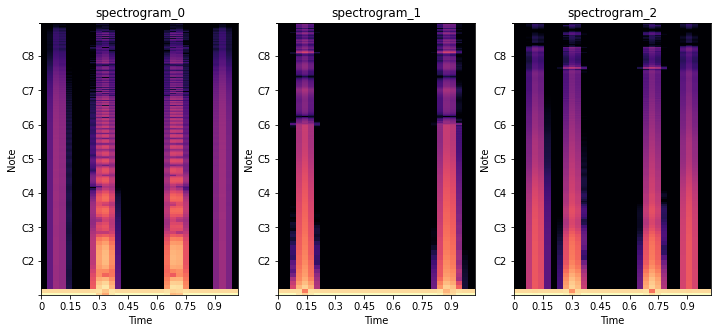

In [ ]:
#@title Visualización de datos { run: "auto" }
ids = list(DATA_filt['id'])
audio_viz = 'spectrogram' #@param ['PCA','F0', 'histogram','spectrogram']
#fig, ax = plt.subplots()
plt.figure(figsize = [12,5])
#fig.set_size_inches([12,5])

if audio_viz == 'histogram':
  ax = plt.subplot(1,1,1)
  ax = DATA_filt['gid'].hist()
  ax.set_xlabel("Synth type")
  ax.set_ylabel(" # of observations")
  plt.show()
if audio_viz == 'F0':
  ax = plt.subplot(1,1,1)
  ax.set_xlabel("Audios")
  ax.set_ylabel(" F0")
  ax.plot(DATA_filt.index, DATA_filt['f0'], linestyle = '--')
  #plt.show()
if audio_viz == 'PCA':
  ax = plt.subplot(1,1,1)
  pca = PCA(n_components= 2)
  X_PCA = pca.fit_transform(Xmu_FFT)
  print('variance: ')
  print(pca.explained_variance_ratio_)
  counter = 0 
  cu = 0

  for key, value in zliders.items():
    #print(key,value)
    ax.scatter(X_PCA[counter: counter + value, 0], X_PCA[counter: counter + value, 1], cmap= 10, label = key)
    counter += value
    cu += 1
  ax.set_title('PCA')
  ax.set_xlabel('PCA 1')
  ax.set_ylabel('PCA 2')
  ax.legend()

if audio_viz == 'spectrogram':
  z = DATA_filt['fft'].sample(3)
  for i, x in enumerate(z):
    ax = plt.subplot(1, 3, i + 1)
    stft = librosa.stft(x)#, n_fft=512, hop_length= (512-1)//2)
    stft = librosa.amplitude_to_db(np.abs(stft),ref=np.max)
    librosa.display.specshow(stft,sr = 16000, y_axis='fft_note', x_axis='time')
    ax.set_title('spectrogram_'+ str(i))
    #ax.set_set_xlabel('time')
  #for idx, id in enumerate(ids):
  #  ax.annotate(id,(X_PCA[idx][0], X_PCA[idx][1]+ 0.2))
  #fig.add_axes(ax)
  
  plt.show()
  


In [ ]:
#@title Entrenamiento del modelo

from google.colab import files
##standarizacion de datos
data = np.vstack(DATA_filt['data'])
mu_wave = np.mean(data, axis= 1)[...,np.newaxis]
max_wave = np.max(data, axis=1)[...,np.newaxis]
Xw = (data- mu_wave)/max_wave
Xw = Xw[...,np.newaxis][...,np.newaxis]

referencia_1 = 'Nuevo modelo' #@param ['Nuevo modelo','Preentrenado','mi modelo']
Epocas = 154 #@param {type:"slider", min:10, max:10000, step:1}
batches = 5 #@param {type: "integer"}
lr = 0.00008 #@param {type: "slider", min:0.00001, max: 0.0001, step:0.00001}

warm_up_iters = 1000 
optimizer = tf.keras.optimizers.Adam(lr, clipvalue=0.5)
if referencia_1 == 'Preentrenado': 
  original_dim = (16000, 1, 1)
  encoder_inputs = keras.Input(original_dim)  
  encoder_pretrained = tf.keras.models.load_model('/content/encoder2_cdmx',compile = False)
  decoder_pretrained = tf.keras.models.load_model('/content/decoder2_cdmx',compile = False)
  outpt = decoder_pretrained(encoder_pretrained(encoder_inputs)[2])
  vae = Model(inputs=encoder_inputs, outputs=outpt, name='VAE-Model')
  vae.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = vae.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)
  latent =  encoder_pretrained.predict(Xw[0:])

if referencia_1 == 'Nuevo modelo': 
  original_dim = (16000, 1, 1)
  encoder_inputs = keras.Input(original_dim)  
  encoder_pretrained = tf.keras.models.load_model('/content/vanilla_encoder',compile = False)
  decoder_pretrained = tf.keras.models.load_model('/content/vanilla_decoder',compile = False)
  outpt = decoder_pretrained(encoder_pretrained(encoder_inputs)[2])
  vae = Model(inputs= encoder_inputs, outputs= outpt, name='VAE-Model')
  vae.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = vae.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)
  latent =  encoder_pretrained.predict(Xw[0:])
else:
  print('.....')
  '''
  new_model = tf.keras.models.load_model('/content/model_vae')
  new_model.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = new_model.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)
  '''


Epoch 1/154
5/5 [==============================] - 1s 48ms/step - loss: 0.1275
Epoch 2/154
5/5 [==============================] - 0s 37ms/step - loss: 0.1275
Epoch 3/154
5/5 [==============================] - 0s 37ms/step - loss: 0.1275
Epoch 4/154
5/5 [==============================] - 0s 38ms/step - loss: 0.1275
Epoch 5/154
5/5 [==============================] - 0s 36ms/step - loss: 0.1275
Epoch 6/154
5/5 [==============================] - 0s 37ms/step - loss: 0.1275
Epoch 7/154
5/5 [==============================] - 0s 36ms/step - loss: 0.1275
Epoch 8/154
5/5 [==============================] - 0s 36ms/step - loss: 0.1275
Epoch 9/154
5/5 [==============================] - 0s 36ms/step - loss: 0.1275
Epoch 10/154
5/5 [==============================] - 0s 36ms/step - loss: 0.1275
Epoch 11/154
5/5 [==============================] - 0s 36ms/step - loss: 0.1275
Epoch 12/154
5/5 [==============================] - 0s 36ms/step - loss: 0.1275
Epoch 13/154
5/5 [==============================]

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


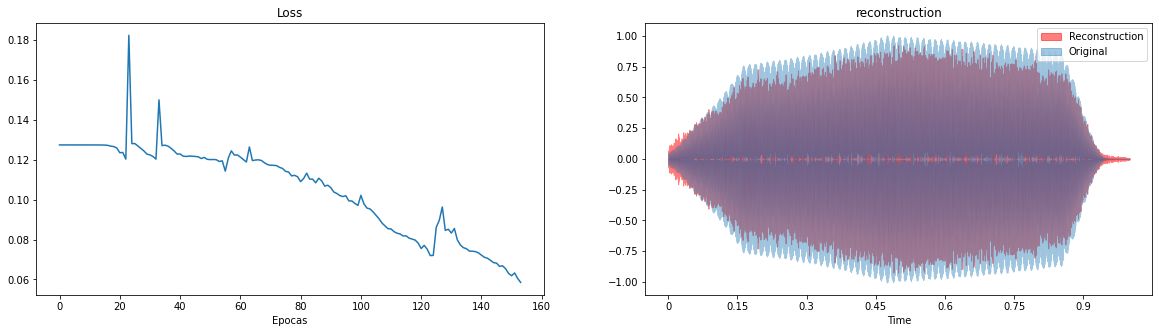

In [ ]:
#@title Evaluación del modelo
#una visualización donde se vea la curva del modelo junto a la recunstruccion

def latent_vectorize(audio_id,df,audio_list):
  audio_idx = list(df[df['id'] == audio_id].index)[0]
  latent_gen = encoder_pretrained.predict(audio_list[audio_idx:])
  return latent_gen[0]

def latent_reconstruction(latent_gen):
  recons = decoder_pretrained.predict(latent_gen[0:])
  recons= recons[0].flatten()
  return recons


def latent_search(audio_id, df, audio_list):
  '''function that retrieves the correct audio representation in the latent space'''
  try:
    latent_gen = latent_vectorize(audio_id,df,audio_list)
    recons = latent_reconstruction(latent_gen)
    return latent_gen, recons
  except TypeError:
    print("audio input must be a valid string")
    
def latent_inter(audio_a, audio_b, step = 100, porcentaje = 50, audio_list = Xw):
  'crea 100 vectores pensados en % y reconstruye'
  if step == 1:
    listas = np.linspace(audio_a, audio_b, step)
    res = latent_reconstruction(listas[porcentaje-1:])
  else:
    listas = np.linspace(audio_a, audio_b, step)
    res = latent_reconstruction(listas[porcentaje-1:])
  return res

'''
def latent_search(audio_id, df, audio_list):
 ''''''function that retrieves the correct audio representation in the latent space''''''
  try:
    audio_idx = list(df[df['id'] == audio_id].index)[0]
    latent_gen = encoder_pretrained.predict(audio_list[audio_idx:])
    recons = decoder_pretrained.predict(latent_gen[0][0:])
    recons= recons[0].flatten()
    return latent_gen, recons
  except TypeError:
    print("audio input must be a valid string")
'''

def gps_latent(dic_tracks, df, data):
  '''search all track ids position in the latent space in an ''orderly fashion'' '''
  res_latent = []
  for key in dic_tracks.keys():
    res_latent.append(latent_search(key, df, data)[0])
  return res_latent

all_tracks_latent = gps_latent(audiotracks, DATA_filt, Xw)



track = random.choices(ids)[0]
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)
fig.set_figheight(5)
ax[0].plot(tr_logs.history['loss'])
librosa.display.waveshow(latent_search(track, DATA_filt, Xw)[1], sr=16000, color='r', alpha=0.5, ax=ax[1], label='Reconstruction')
librosa.display.waveshow(Xw[audiotracks[track]].flatten(), sr=16000, alpha=0.4, ax=ax[1], label='Original')
ax[1].legend()
ax[0].set_xlabel("Epocas")
ax[0].set_title('Loss')
ax[1].set_title('reconstruction')


####archivos de audio
IPython.display.display(IPython.display.Audio(Xw[audiotracks[track]].flatten(), rate = sr16k))
IPython.display.display(IPython.display.Audio(latent_search(track, DATA_filt, Xw)[1],rate = sr16k))

1/1 [==============================] - 0s 292ms/step


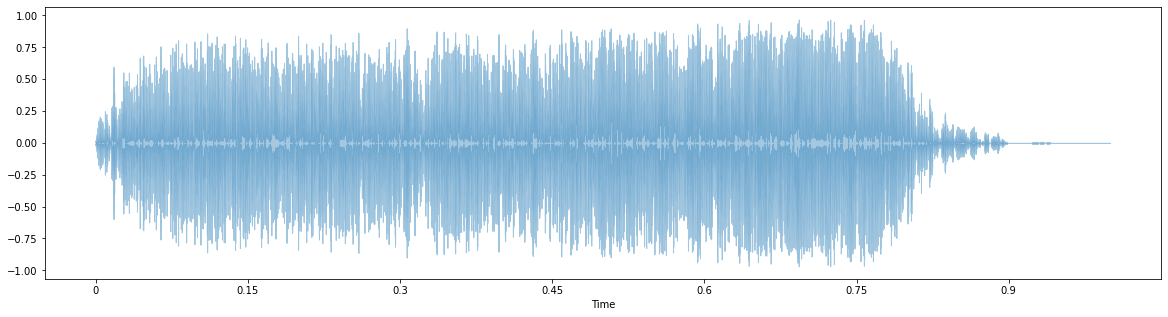

In [ ]:
#@title Exploración y generación { run: "auto" }
audio_id = 'fm1' #@param {type:"string"}
audio_id2 = 'fm2' #@param {type:"string"}

porcentaje_de_cambio = 10 #@param {type:"slider", min:1, max:10, step:1}
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(5)

idx = list(DATA_filt[DATA_filt['id'] == audio_id].index)[0]
idx2 = list(DATA_filt[DATA_filt['id'] == audio_id2].index)[0]
audio_a = all_tracks_latent[0][idx]
audio_b = all_tracks_latent[0][idx2]
inter = latent_inter(audio_a, audio_b, 10, porcentaje_de_cambio)

#a_1 = latent_search(audio)[0]
#a_2 = latent_search(audio)[0]

#inter = latent_inter(a_1,a_2, 100, porcentaje_de_cambio)
#ax.plot(inter)
librosa.display.waveshow(inter, sr=16000, alpha=0.4, label='Original')
IPython.display.display(IPython.display.Audio(inter, rate = sr16k))



******
*
*
*
*
*
*
*
*
*
*
*
*




******

******
*
*
*
*
*
*
*
*
*
*
*
*




******

******
*
*
*
*
*
*
*
*
*
*
*
*




******

In [ ]:
#@title Descarga de materiales
!zip -r /content/model_vae.zip /content/model_vae

modelo = True #@param {type:"boolean"}
espacio_latente = True #@param {type:"boolean"}
boolean_checkbox = True #@param {type:"boolean"}

if modelo == True:
  files.download('/content/model_vae.zip')

'am_4.wav'

In [1]:
from scipy.io import wavfile
SR = 44100
def get_val(osc, sample_rate=SR):
    return [next(osc) for i in range(sample_rate)]

def plot_osc(Osc, name=""):
    fig = plt.figure(figsize=figsize)

    f = 8
    plt.title(f"{f}Hz {name} Wave")
    for a,p,c in zip([1.0,0.9,0.8,0.7],[0,15,30,45],colors):
        osc = Osc(freq=f,amp=a,phase=p); iter(osc)
        plt.plot(get_val(osc), color=c, label=f"amp:{a}, phase:{p:02}°")

    plt.legend(loc='lower right')
    fig.savefig(f"{name.lower()}_all.jpg")

def get_seq(osc, dur):
    samples = []
    osc = iter(osc)
    for _ in range(int(SR * dur)):
      samples.append(next(osc))
    return samples

to_16 = lambda wav, amp: np.int16(wav * amp * (2**15 - 1))

def wave_to_file(wav, wav2=None, fname="temp.wav", amp=0.1):
    wav = np.array(wav)
    wav = to_16(wav, amp)
    if wav2 is not None:
        wav2 = np.array(wav2)
        wav2 = to_16(wav2, amp)
        wav = np.stack([wav, wav2]).T
    
    wavfile.write(fname, SR, wav)

In [62]:
def envelope(atk,dcy,susTime,rel, durs, sr):
 env = np.concatenate((np.linspace(0,atk,int(durs[0]*sr/1)), np.linspace(atk,dcy, int(durs[1]*sr/1)), np.linspace(susTime,susTime, int(durs[2]*sr/1)),np.linspace(susTime,0, int(durs[3]*sr/1))),axis = None)
 return env

In [110]:
def sinusoid(freq=440.0, dur=1.0, srate=16000, amp=1.0, phase = 0.0): 
    t = np.linspace(0,dur,int(srate*dur))
    data = amp * np.sin(2*np.pi*freq *t+phase)
    return data

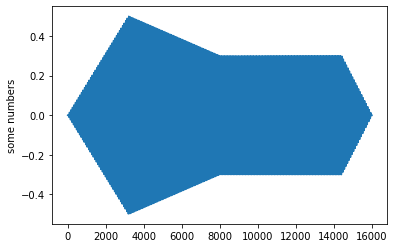

In [81]:

z = envelope(0.5,0.3,0.3,0.1,[0.2,0.3,0.4,0.1], 16000*1)
s = sinusoid(100)
s = am([100,1],2)
s = addsyn(200,1,[0.5,0.2,0.1])
#s = fm([100,23],1,10)
signal = s * z
import matplotlib.pyplot as plt
plt.plot(s*z)
plt.ylabel('some numbers')
plt.show()

In [23]:
def fm(freqs,dur,k):
  carrier = sinusoid(freqs[0],1,16000*dur,1)
  mod = k * sinusoid(freqs[1],1,16000*dur)
  sig = np.cos(carrier + mod)
  return sig

In [ ]:
sig = am([440,10],1,16000,[1,0.4],0)

In [ ]:
sig = fm([440,10],1,16000,[1,20],0)

In [ ]:
z = envelope(0.5,0.3,0.3,0.1,[0.2,0.3,0.4,0.1], 16000)


(16000,)

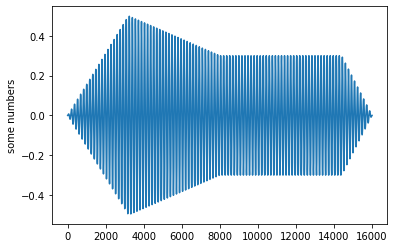

In [36]:

z = envelope(0.5,0.3,0.3,0.1,[0.2,0.3,0.4,0.1], 16000*1)
s = sinusoid(100)
#s = am([100,1],2)
#s = addsyn(200,1,[0.5,0.2,0.1,0.1,0.1])

#s = fm([100,23],1,10)
signal = samples * z
import matplotlib.pyplot as plt
plt.plot(s*z)
plt.ylabel('some numbers')
plt.show()


In [108]:
from scipy.signal import butter, filtfilt
from scipy import signal
import math
from scipy.signal import butter, sosfilt, sosfreqz


class SynthGen:
  """This class returns a synth"""
  def __init__(self, sr , envelope):
    self.sr = sr
    #self.osc = osc
    self.env = envelope
    
   ######aun hay que arreglar que carge la carga de la señal 
   
  def sinusoid(self, freq = 100, dur=1.0, amp= 1.0, phase = 0.0): 
    t = np.linspace(0,dur,int( self.sr * dur))
    osc = amp * np.sin(2*np.pi* freq * t + phase)
    self.osc = osc

  def am(self, c_freq= 100.0, m_freq = 10.0, dur = 1):
    sig = self.osc(c_freq,dur) * self.osc(m_freq, dur)
    return sig * self.env

  def fm(self, c_freq = 100, mod_freq = 10, index_mod = 3, dur = 1):
    carrier = self.osc(c_freq, dur, 1)
    mod = index_mod * self.osc(mod_freq, dur)
    sig = np.cos(carrier + mod)
    return sig * self.env

  def fm(self, c_freq = 100, mod_freq = 10, index_mod = 3, dur = 1):
    carrier = self.osc(c_freq, dur, 1)
    mod = index_mod * self.osc(mod_freq, dur)
    sig = np.cos(carrier + mod)
    return sig * self.env
  
  def additive(self, freq = 100, dur= 1, amplist= []):
    i = 1
    t = np.linspace(0, dur, math.ceil(self.sr * dur))
    ### initialize a new output
    sig = np.zeros(t.size)
    for num in amplist:
        x = np.multiply(self.osc(freq * i, dur), num)
        ### sum it to the output
        sig = sig + x
        i+=1
    ### making sure the maximum amplitude does not exeed 1
    if np.max(sig)>abs(np.min(sig)):
        sig = sig / np.max(sig)
    else:
        sig = sig / -np.min(sig)
    return sig * self.env
  
  def sustractive(self, lowcut= 800, highcut = 1000):
    
    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

    def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
            sos = butter_bandpass(lowcut, highcut, fs, order=order)
            y = sosfilt(sos, data)
            return y
        
    num_samples = self.sr
    sig = np.random.rand(num_samples) * 2 - 1
    sig = butter_bandpass_filter(sig, lowcut, highcut, num_samples)
    
    return sig

In [109]:
sr = 16000
z = envelope(0.5,0.3,0.3,0.1,[0.2,0.3,0.4,0.1], 16000*1)
synth = SynthGen(sr, z)
s = synth.am()


#z = synth.sustractive()

plt.plot(s)
plt.ylabel('some numbers')
plt.show()

AttributeError: ignored

In [104]:
sr = 16000
z = envelope(0.5,0.3,0.3,0.1,[0.2,0.3,0.4,0.1], 16000*1)
synth = SynthGen(sr, z)
s = synth.additive(60,1,[0.3,0.3,0.3,0.1])
s = synth.am()
s = synth.fm()

#z = synth.sustractive()

plt.plot(AM[3])
plt.ylabel('some numbers')
plt.show()

AttributeError: ignored

In [97]:
import IPython
IPython.display.display(IPython.display.Audio(AM[1], rate = 16000))


In [28]:
env= {'atk': [0,100], 'dcy': [0,100], 'sus': [0,100], 'rel': [0,100]}
x = [widgets.IntRangeSlider(value=[40,60], min=env[key][0], max=env[key][1], step=1, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)for key in env.keys()]
x

[IntRangeSlider(value=(40, 60), continuous_update=False, description='atk'),
 IntRangeSlider(value=(40, 60), continuous_update=False, description='dcy'),
 IntRangeSlider(value=(40, 60), continuous_update=False, description='sus'),
 IntRangeSlider(value=(40, 60), continuous_update=False, description='rel')]

In [95]:
from ipywidgets import HBox, VBox
import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout
env= {'atk%': [0,100], 'dcy%': [0,100], 'sus%': [0,100], 'rel%': [0,100]}
am_param = {'carrier_freq': [20,8000],'mod_freq':[20,8000]}

env = [widgets.IntRangeSlider(value=[40,60], min=env[key][0], max=env[key][1], step=1, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)for key in env.keys()]

am = [widgets.IntRangeSlider(value=[2881,5550], min=am_param[key][0], max=am_param[key][1], step=1, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)for key in am_param.keys()]

gen = [widgets.BoundedIntText(value=7, min=0, max=10,step=1,description='AMOUNT:',disabled=False),widgets.Button(description='GENERATE', disabled=False,button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)]

button = widgets.Button(
    description='Plot',
)

tab1 = HBox(children = [VBox(children= env),
                        VBox(children= am) ,
                        VBox(children= [button]),
                        VBox(children = gen)])
                        
tab2 = HBox(children = [VBox(children= env),VBox(children= env) ,VBox(children= env)])
tab3 = HBox(children = [VBox(children= env),VBox(children= env) ,VBox(children= env)])
tab4 = HBox(children = [VBox(children= env),VBox(children= env) ,VBox(children= env)])


tab2 = VBox(children=[widgets.IntRangeSlider(
    value=[5, 7],
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)])

AM = []

@button.on_click
def boton_action(b=None):
  for i in range(gen[0].value):
    #print(am[0].value)
    car_val = sorted(am[0].value)
    port_val = sorted(am[1].value)
    AM.append(synth.am(np.random.randint(car_val[0],car_val[1], size=1)[0],np.random.randint(port_val[0],port_val[1], size=1)[0], 1))

tab = widgets.Tab()
tab.children = [tab1,tab2,tab3,tab4]
tab.set_title(0,"am")
tab.set_title(1,"fm")
tab.set_title(2,"additive")
tab.set_title(3,"sustractive")


tab

In [94]:
#np.random.randint(2000, 200, size=1)[0]
car_val = sorted(am[0].value)
car_val

[1381, 3300]

In [24]:
#@title Carga de audios { run: "auto" }
## 
import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout
from google.colab import files

dropdown = 'Subir archivos' #@param ["Subir archivos", "crear", "grabar"]
if dropdown == 'Subir archivos':
  pass
if dropdown ==  'crear': 
  print('efkwjefwkf')
  display(tab)

if dropdown == 'grabar':
  pass